In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

# Data Import and Cleaning 

In [3]:
#shared_dir_path = os.environ["SHARED_DATA_DIR"] + '/'
shared_dir_path = '' # sub this out for above comment when using in notable
path = shared_dir_path + 'ESDA2_GroupProject_Data/'

In [4]:
# read glacier data
file = 'glacier_area.xlsx'
file_path = path + file
glacier_area = pd.read_excel(file_path)

In [5]:
# make a dict of each glacier location
glacier_locations = glacier_area[['Glacier', 'Latitude', 'Longitude']].set_index('Glacier').T
glacier_locations = glacier_locations.rename(index={'Latitude': 'lat', 'Longitude': 'lon'})
glacier_locations = glacier_locations.to_dict()

In [6]:
# drop lat/lon data and convert to timeseries index
glacier_timeseries = glacier_area.drop(['Latitude', 'Longitude'], axis=1).set_index('Glacier').T
glacier_timeseries.index = pd.to_datetime(glacier_timeseries.index)

In [7]:
# read station metdata
file = '420800.csv'
file_path = path + file
station_420800 = pd.read_csv(file_path, delimiter=';')

file = '422100.csv'
file_path = path + file
station_422100 = pd.read_csv(file_path, delimiter=';')

file = '425000.csv'
file_path = path + file
station_425000 = pd.read_csv(file_path, delimiter=';')

file = '430100.csv'
file_path = path + file
station_430100 = pd.read_csv(file_path, delimiter=';')

file = '432000.csv'
file_path = path + file
station_432000 = pd.read_csv(file_path, delimiter=';')

file = '436000.csv'
file_path = path + file
station_436000 = pd.read_csv(file_path, delimiter=';')

file = 'station_details.xlsx'
file_path = path + file
station_details = pd.read_excel(file_path)

In [8]:
# clean station data to be airtemp timeseries
metdata_420800 = station_420800.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_420800['Date'] = pd.to_datetime(metdata_420800[['Year', 'Month', 'Day', 'Hour']])
metdata_420800 = metdata_420800.set_index('Date')
metdata_420800 = metdata_420800[['airtemp']]

metdata_422100 = station_422100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_422100['Date'] = pd.to_datetime(metdata_422100[['Year', 'Month', 'Day', 'Hour']])
metdata_422100 = metdata_422100.set_index('Date')
metdata_422100 = metdata_422100[['airtemp']]

metdata_425000 = station_425000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_425000['Date'] = pd.to_datetime(metdata_425000[['Year', 'Month', 'Day', 'Hour']])
metdata_425000 = metdata_425000.set_index('Date')
metdata_425000 = metdata_425000[['airtemp']]

metdata_430100 = station_430100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_430100['Date'] = pd.to_datetime(metdata_430100[['Year', 'Month', 'Day', 'Hour']])
metdata_430100 = metdata_430100.set_index('Date')
metdata_430100 = metdata_430100[['airtemp']]

metdata_432000 = station_432000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_432000['Date'] = pd.to_datetime(metdata_432000[['Year', 'Month', 'Day', 'Hour']])
metdata_432000 = metdata_432000.set_index('Date')
metdata_432000 = metdata_432000[['airtemp']]

metdata_436000 = station_436000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_436000['Date'] = pd.to_datetime(metdata_436000[['Year', 'Month', 'Day', 'Hour']])
metdata_436000 = metdata_436000.set_index('Date')
metdata_436000 = metdata_436000[['airtemp']]

# set a dict to make each station accessible later
metdata = {
    '420800': metdata_420800,
    '422100': metdata_422100,
    '425000': metdata_425000,
    '430100': metdata_430100,
    '432000': metdata_432000,
    '436000': metdata_436000
}

In [9]:
# read sst netCDF file
file = 'HadISST_SST_northatlantic.nc'
file_path = path + file
ds = nc.Dataset(file_path)

# isolate variables
sst_timedelta = ds.variables['time'][:]
sst_lat = ds.variables['latitude'][:]
sst_lon = ds.variables['longitude'][:]
sst = ds.variables['sst'][:,:,:]

In [10]:
# convert time from start to a date
sst_time = pd.to_timedelta(sst_timedelta, unit='D') + pd.Timestamp('1870-01-01 00:00:00')

In [11]:
# map below freezing values to frozen value (1.8)
mask_value = -1.8
freezing_point = -1.8
sst[sst < mask_value] = freezing_point

# Functions

In [12]:
# pick what SST values corresponds to chosen glacier
def pick_closest_SST(lats, lons, sst, glacier):
    """
    lats: 1D array of latitudes
    lons: 1D array of longitudes
    sst: 3D array of sea surface temp at (time, latitude, longitude)
    glacier: (lat, lon); a tuple of glacier coordinates

    returns: ind_lat, ind_lon -> indices to get sst data closest to glacier
    """
    sst_slice = sst[-1, :, :]   # last time step
    mask = sst_slice.mask
    
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    dist = np.sqrt((lat2d - glacier[0])**2 + (lon2d - glacier[1])**2)

    dist_masked = np.ma.array(dist, mask=mask)

    pair = np.unravel_index(np.argmin(dist_masked), dist_masked.shape)

    ind_lat = pair[0]
    ind_lon = pair[1]
    
    return ind_lat, ind_lon

In [13]:
# find closest station (airtemp) for chosen glacier
def pick_closest_airtemp(station_details, glacier_location):
    """
    station_details: dataframe with columns 'Station Code', 'Latitude', 'Longitude'
    target_lat: latitude of glacier
    target_lon: longitude of glacier

    returns: station_code -> code of closest station
    """
    target_lat, target_lon = glacier_location
    lats = station_details['Latitude'].values
    lons = station_details['Longitude'].values
    station_codes = station_details['Station number'].values

    dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)

    min_index = np.argmin(dist)

    station_number = station_codes[min_index]

    return station_number   

In [14]:
# create df of robust yearly averaged values (inner join) for chosen glacier
def get_glacier_df(GLACIER, SAMPLE_TIME):

    target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])

    # get data from closest met station
    station_number = pick_closest_airtemp(station_details, target_location)
    glacier_metdata = metdata[str(station_number)]

    # take only year where we have data for all months - avoids bias from missing months, as temp varies seasonally
    glacier_metdata = glacier_metdata[~glacier_metdata['airtemp'].isna()]
    months_per_year = glacier_metdata.groupby(glacier_metdata.index.year).apply(lambda x: x.index.month.nunique())
    valid_years = months_per_year[months_per_year == 12].index
    glacier_metdata = glacier_metdata[glacier_metdata.index.year.isin(valid_years)]

    # get SST data from closest grid point and convert to time series
    ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
    glacier_sst = sst[:, ind_lat, ind_lon]
    glacier_sst = pd.DataFrame({'Date': sst_time, 'SST': glacier_sst})
    glacier_sst = glacier_sst.set_index('Date')

    # align time series to common start date
    start = max(glacier_timeseries.index[0], glacier_metdata.index[0], glacier_sst.index[0])

    glacier_area_series = glacier_timeseries[GLACIER][glacier_timeseries.index >= start]
    glacier_metdata_series = glacier_metdata[glacier_metdata.index >= start]
    glacier_sst_series = glacier_sst[glacier_sst.index >= start]

    # resample time series
    glacier_area_resampled = glacier_area_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_metdata_resampled = glacier_metdata_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_sst_resampled = glacier_sst_series.resample(SAMPLE_TIME).mean().dropna()

    # join time series into single dataframe
    glacier_df = pd.concat([glacier_area_resampled, glacier_metdata_resampled, glacier_sst_resampled], axis=1, join='inner')
    glacier_df = glacier_df.rename(columns={GLACIER: 'area'})
    
    return glacier_df

# Question 1

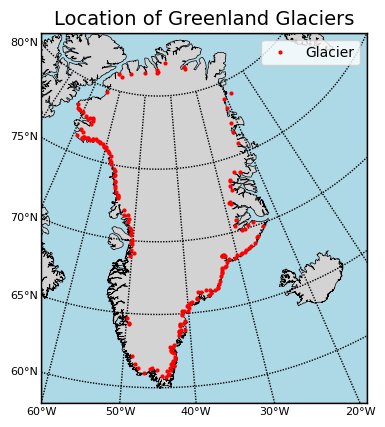

In [15]:
# create and plot map of glacier locations
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# get xy coordinated of glaciers from lat/lon
lons = [glacier_locations[key]['lon'] for key in glacier_locations]
lats = [glacier_locations[key]['lat'] for key in glacier_locations]
x, y = m(lons, lats)

# Plot the point locaitons
m.plot(x, y, 'ro', markersize=2, label='Glacier')

# customise plot
plt.title('Location of Greenland Glaciers', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper right')
plt.show()

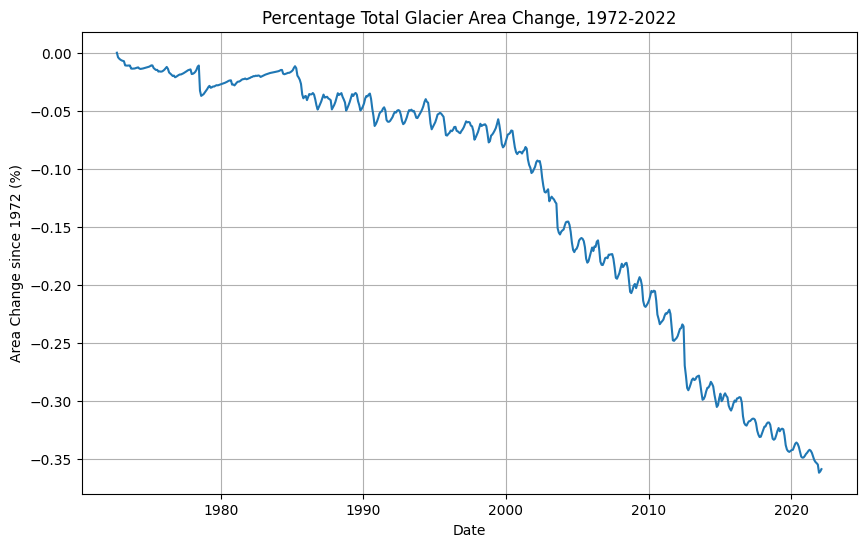

In [16]:
# timersiers plot of total area % change in glacier area
# calculate percentage loss
sum_areas = glacier_timeseries.sum(axis=1)
pct_loss = (sum_areas - sum_areas.iloc[0]) / sum_areas.iloc[0] * 100 # percentage

# plot percentage loss
plt.figure(figsize=(10,6))
plt.plot(pct_loss.index, pct_loss)
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Glacier Area Change, 1972-2022')
plt.grid()
plt.show()

In [17]:
# what does 0.1% correlate to
print(f"{sum_areas.iloc[0]*0.1/100:.2f}km^2")

1317.42km^2


In [18]:
# how much total area lost 1972-2022
print(f"{sum_areas.iloc[0] - sum_areas.iloc[-1]:.2f}km^2")

4725.17km^2


# Question 2

# Question 3

# Question 4

# Question 5